In [1]:
import rosbag
import numpy as np
import os
import matplotlib.pylab as plt
import cv2

In [2]:
def generate_integrated_img(bag, n_events=50000, n_fill=4, img_size=[720, 1280]):
    xs = []
    ys = []
    cnt = 0
    for topic, msg, t in bag:
        if topic=='/prophesee/camera/cd_events_buffer':
            for event in msg.events:
                xs.append(event.x)
                ys.append(event.y)
                cnt += 1
            if cnt >= n_events:
                break
        if cnt >= n_events:
            break

    integrated_img = np.ones(img_size + [3]) * 255

    for x, y in zip(xs, ys):
        integrated_img[y-n_fill : y+n_fill, x-n_fill : x+n_fill] = np.array([1, 1, 1])
    integrated_img = integrated_img.astype(np.uint8)
    return integrated_img

In [3]:
i = 0
pattern_size = (6, 6)
square_size = 2.2 #[cm]

pattern_points = np.zeros( (np.prod(pattern_size), 3), np.float32 )
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= square_size

In [4]:
imgs = []
imgpoints = []
objpoints = []

i = 0
while True:
    bagpath = '/home/koji/dvs/calibration/data/prophesee_rosbag/rec{}.bag'.format(i)
    if not os.path.exists(bagpath):
        break
    bag = rosbag.Bag(bagpath)
    integrated_img = generate_integrated_img(bag)
    imgs.append(integrated_img)
    ret, corner = cv2.findChessboardCorners(integrated_img, pattern_size)
    if ret:
        print('#{}: Corner detected.'.format(i))
        imgpoints.append(corner.reshape(-1, 2))
        objpoints.append(pattern_points)
    else:
        print('#{}: Not detected.'.format(i))
    i += 1

#0: Corner detected.
#1: Corner detected.
#2: Corner detected.
#3: Corner detected.
#4: Corner detected.
#5: Corner detected.
#6: Corner detected.


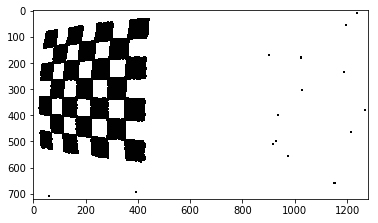

In [5]:
plt.imshow(imgs[2])

In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (1280, 720), None, None)

In [7]:
mtx, dist

(array([[1.02839267e+03, 0.00000000e+00, 6.42907688e+02],
        [0.00000000e+00, 1.03943630e+03, 3.09842219e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-4.31668238e-01,  2.17652821e-01,  4.27917312e-04,
         -1.69768444e-03, -6.51957281e-02]]))

In [8]:
h, w = imgs[2].shape[:2]
newcameramatrix, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

In [9]:
dst = cv2.undistort(imgs[2], mtx, dist, None, newcameramatrix)

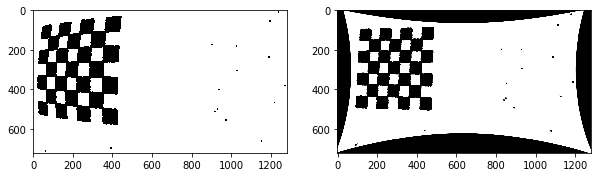

In [16]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
axL.imshow(imgs[2])
axR.imshow(dst)
plt.show()